In [14]:
import os, glob, math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [134]:
class FacialKeyPointsDataset(Dataset):
    
    def __init__(self, csv_file, n_keypoints, size, transform):
        """
        Args:
            csv_file (string): csv file with facial keypoints and pixel values for all images
            n_keypoints (int): number of facial keypoints (w, h)
            size (int,int): shape of image
        """
        
        self.df = self.filter_by_n_kpts(csv_file, n_keypoints)
        self.kp_mean = self.df.iloc[:,:30].stack().mean()
        self.kp_std = self.df.iloc[:,:30].stack().std()
        self.n_keypoints = n_keypoints
        self.size = size
        self.transform = transform


    def filter_by_n_kpts(self, csv_file, n_keypoints):
        
        df = pd.read_csv(csv_file)
        notnan = df.apply(lambda x: np.sum(~x[:30].isnull()), axis=1)
        subdf = df[notnan == n_keypoints * 2]
        subdf = subdf.reset_index(drop=True)
        
        return subdf
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        img = np.array(self.df.iloc[idx, 30].split())
        w, h = self.size
        img = img.astype(np.float32).reshape(w, h)
        #img = np.expand_dims(img, axis=0)

        keypts = self.df.iloc[idx,:30].values
        keypts = keypts.reshape(-1, 1)
        keypts = keypts.astype('float')
        
        if self.n_keypoints == 4:
            keypts = keypts[~np.isnan(keypts)]
        
        heatmaps = []        
        for i in range(0, len(keypts)//2):
            x = int(keypts[i * 2])
            y = int(keypts[i * 2 + 1])
            heatmap = self.gaussian(x, y, w, h)
            heatmaps.append(heatmap)
            
        heatmaps = np.array(heatmaps)
        
        if self.transform:
            img = self.transform(img)
            heatmaps = self.transform(heatmaps)
    
        heatmaps = heatmaps.transpose(0,1)
        heatmaps = heatmaps.transpose(1,2)
        
        return img, heatmaps
    
    
    def gaussian(self, xL, yL, H, W, sigma=5):
        channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        channel = np.array(channel, dtype=np.float32)
        channel = np.reshape(channel, newshape=(H, W))

        return channel
    
    
    def show_sample(self, img, heatmaps):
        plt.imshow(img.reshape(self.size), cmap='gray', alpha=0.5)
        plt.imshow(heatmaps.sum(axis=0), alpha=0.5)
    
    
    def display_samples(self, n=3):
        fig = plt.figure(figsize=(10, 5))
        fig.tight_layout()
        for i in range(n):
            rand_i = np.random.randint(0, len(self.df))
            img, heatmaps = self.__getitem__(rand_i)

            print(i, img.shape, heatmaps.shape)
            fig.add_subplot(1, n, i + 1)
            self.show_sample(img, heatmaps)
        fig.savefig('samples/heatmaps.png')


In [135]:
def get_dataset(n_keypoints):
    
    tsfm = transforms.Compose([transforms.ToTensor()])
    dataset = FacialKeyPointsDataset(csv_file='data/training.csv',
                                     n_keypoints=n_keypoints,
                                     size=(96,96),
                                     transform=tsfm)
    return dataset
    
fkp = get_dataset(n_keypoints=15)
len(fkp)

2140

0 torch.Size([1, 96, 96]) torch.Size([15, 96, 96])
1 torch.Size([1, 96, 96]) torch.Size([15, 96, 96])
2 torch.Size([1, 96, 96]) torch.Size([15, 96, 96])


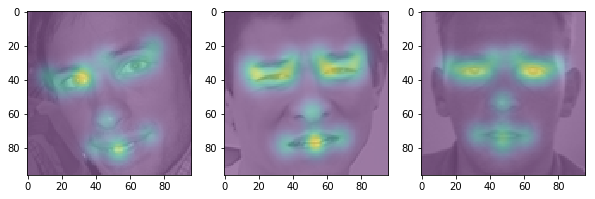

In [138]:
fkp.display_samples(n=3)